In [1]:
# Imports
import pathlib

import numpy as np
import torch
from skimage.io import imread
from skimage.transform import resize

from inference import predict
from transformations import normalize_01, re_normalize
from unet import UNet
import cv2
# root directory

## Below is the path to data (It expects two subdirectories within i.e. 'images' and 'targets')

root = pathlib.Path(r'C:\Users\Lenovo\Downloads\extracted_data_bag_images\extracted_data')
def get_filenames_of_path(path: pathlib.Path, ext: str = "*"):
    """Returns a list of files in a directory/path. Uses pathlib."""
    filenames = [file for file in path.glob(ext) if file.is_file()]
    return filenames


# input and target files
images_names = get_filenames_of_path(root / "images")
# images_names = get_filenames_of_path(root)
targets_names = get_filenames_of_path(root / "targets")

# read images and store them in memory
images = [imread(str(img_name)) for img_name in images_names]
targets = [imread(tar_name) for tar_name in targets_names]

# Resize images and targets
images_res = [resize(img, (64,64, 3)) for img in images]
resize_kwargs = {"order": 0, "anti_aliasing": False, "preserve_range": True}
targets_res = [resize(tar, (64, 64), **resize_kwargs) for tar in targets]


In [2]:
# device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# model
# out-channels is the number of segementation classes
model = UNet(
    in_channels=3,
    out_channels=4,
    n_blocks=4,
    start_filters=32,
    activation="relu",
    normalization="batch",
    conv_mode="same",
    dim=2,
).to(device)

## path to the trained checkpoints
model_name = "checkpoints\experiment_lr_on_plateau_dataset_large_color_aug_1717479001.1984859/epoch_200.pth"
model_weights = torch.load(pathlib.Path.cwd() / model_name, map_location=device)

model.load_state_dict(model_weights)


<All keys matched successfully>

In [3]:
# preprocess function
def preprocess(img: np.ndarray):
    img = np.moveaxis(img, -1, 0)  # from [H, W, C] to [C, H, W]
    img = normalize_01(img)  # linear scaling to range [0-1]
    img = np.expand_dims(img, axis=0)  # add batch dimension [B, C, H, W]
    img = img.astype(np.float32)  # typecasting to float32
    return img


# postprocess function
def postprocess(img: torch.tensor):
    img = torch.argmax(img, dim=1)  # perform argmax to generate 1 channel
    img = img.cpu().numpy()  # send to cpu and transform to numpy.ndarray
    img = np.squeeze(img) # remove batch dim and channel dim -> [H, W]
    img = re_normalize(img)  # scale it to the range [0-255]
    return img


In [4]:
# predict the segmentation maps
output = [predict(img, model, preprocess, postprocess, device) for img in images_res]


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\skimage\util\dtype.py:550: UserWarning: Downcasting int64 to uint8 without scaling because max value 2 fits in uint8
  return _convert(image, np.uint8, force_copy)


1


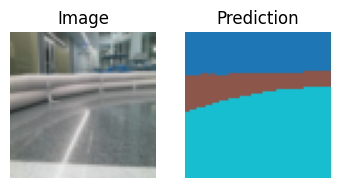

2


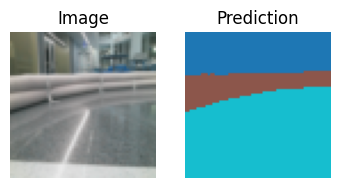

3


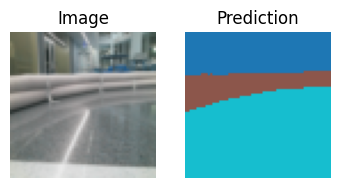

4


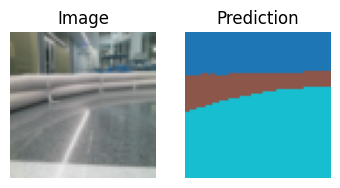

5


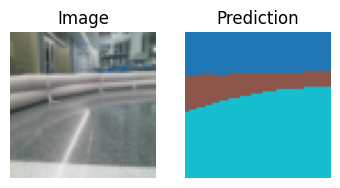

6


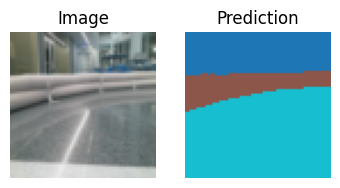

7


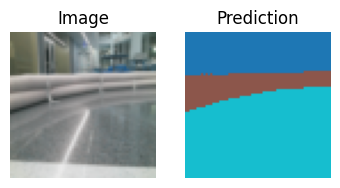

8


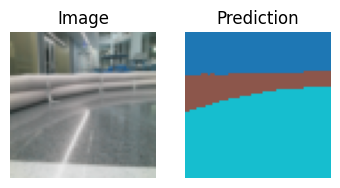

9


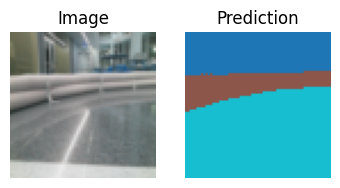

10


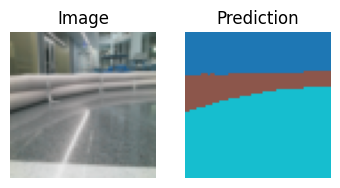

11


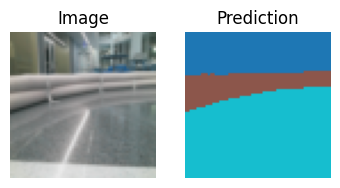

12


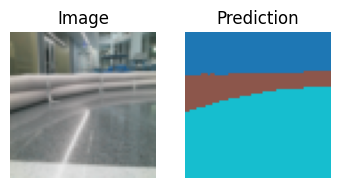

13


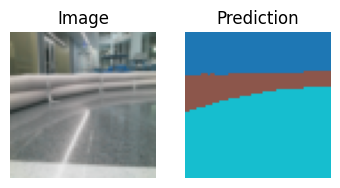

14


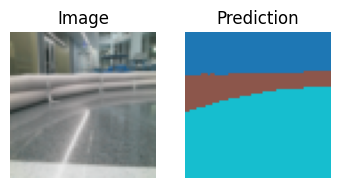

15


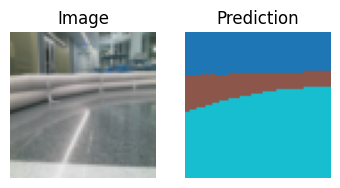

16


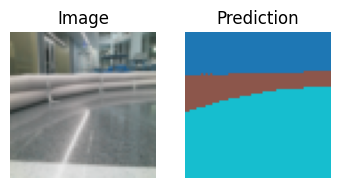

17


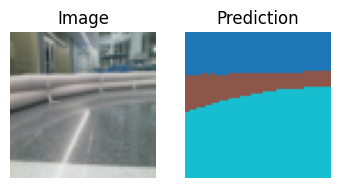

18


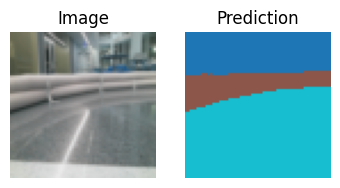

19


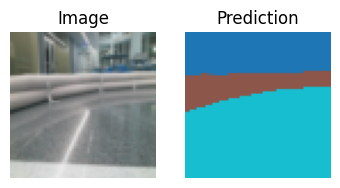

20


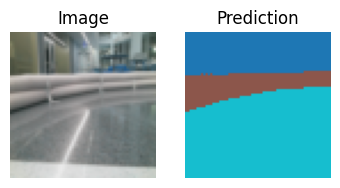

21


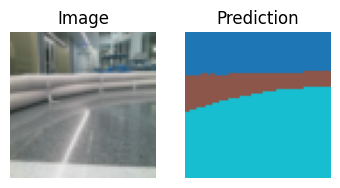

22


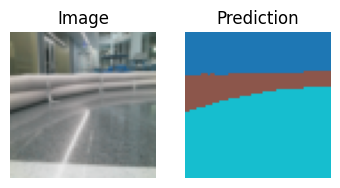

23


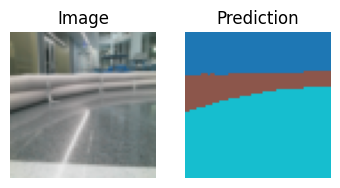

24


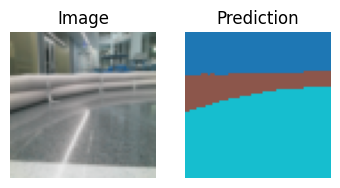

25


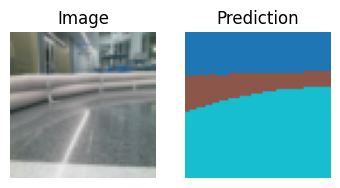

26


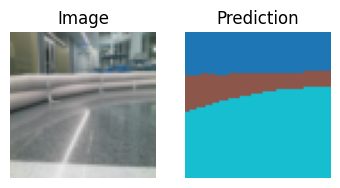

27


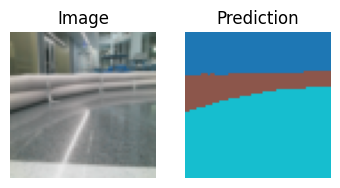

28


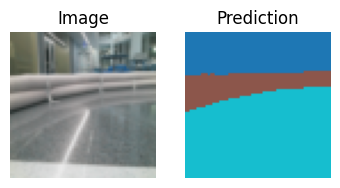

29


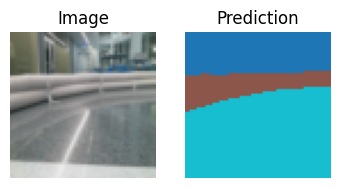

30


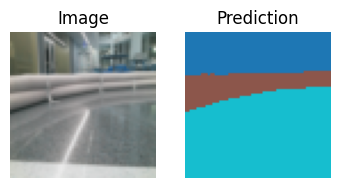

31


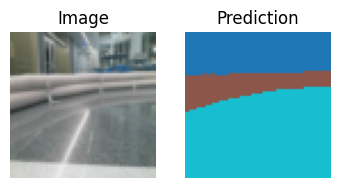

32


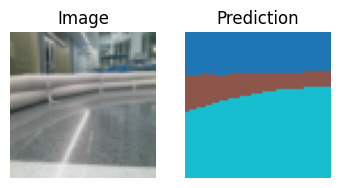

33


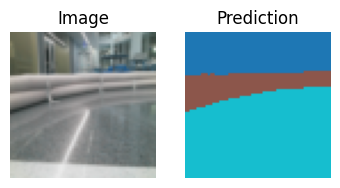

34


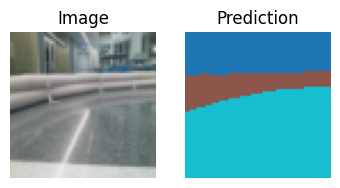

35


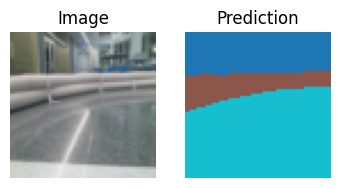

36


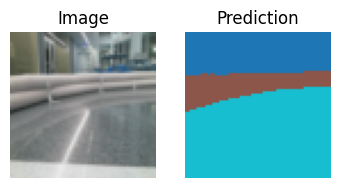

37


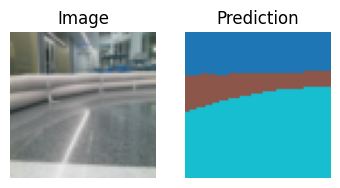

38


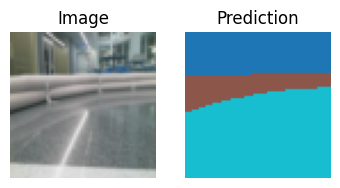

39


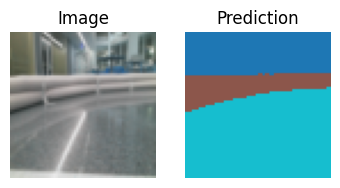

40


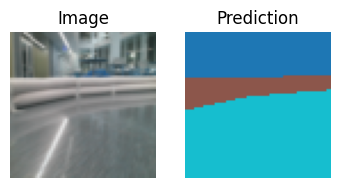

41


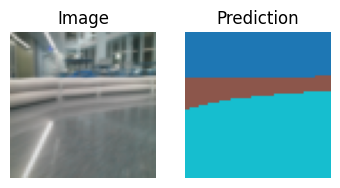

42


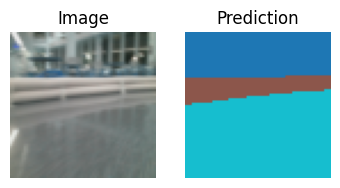

43


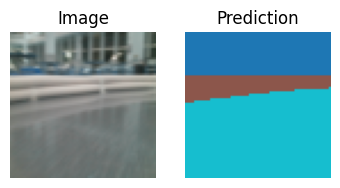

44


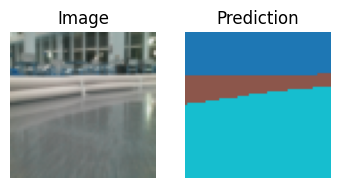

45


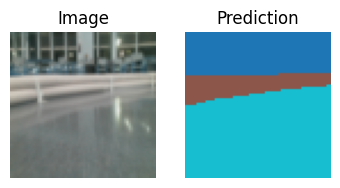

46


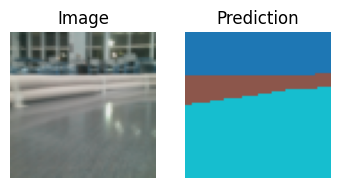

47


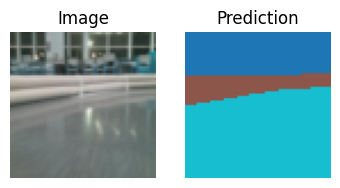

48


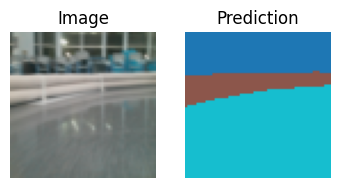

49


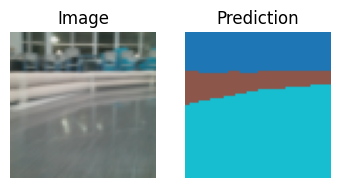

50


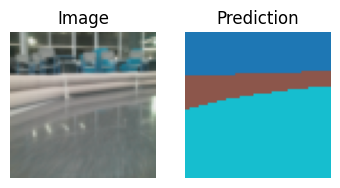

51


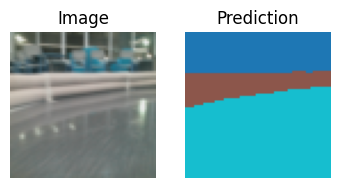

52


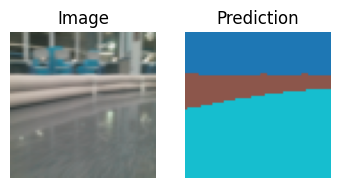

53


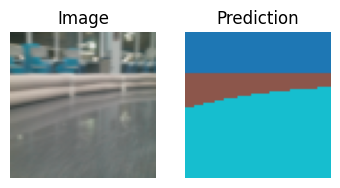

54


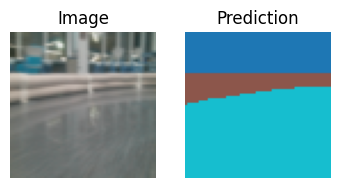

55


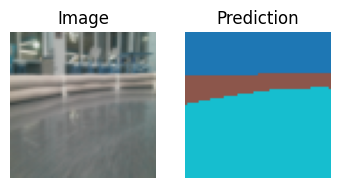

56


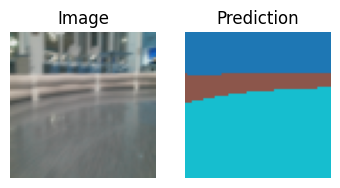

57


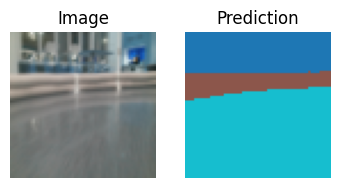

58


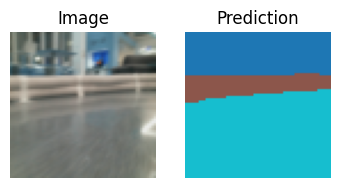

59


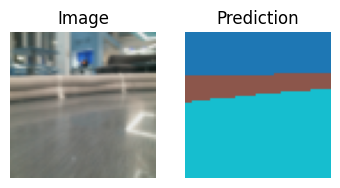

60


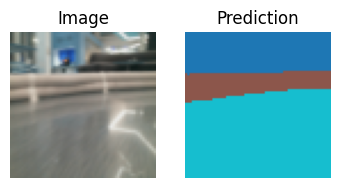

61


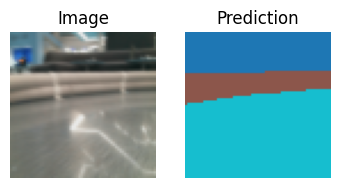

62


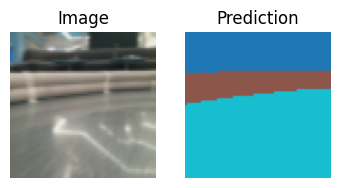

63


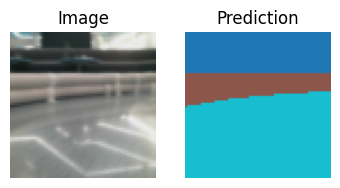

64


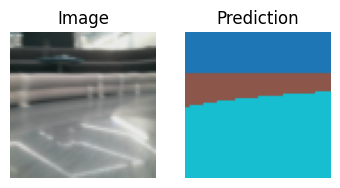

65


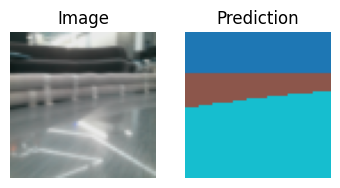

66


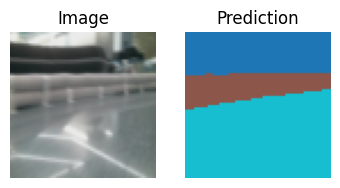

67


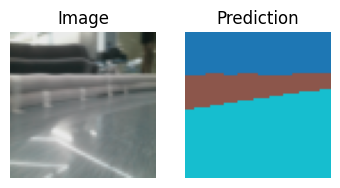

68


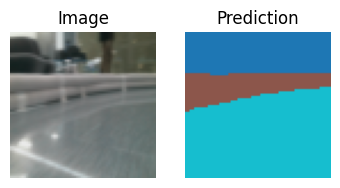

69


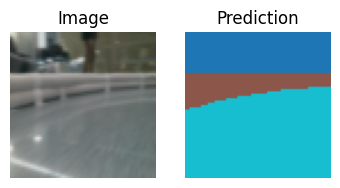

70


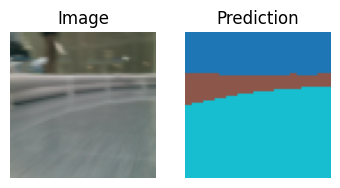

71


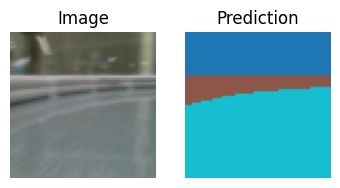

72


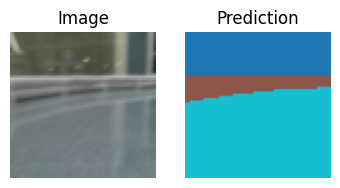

73


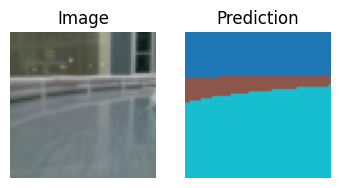

74


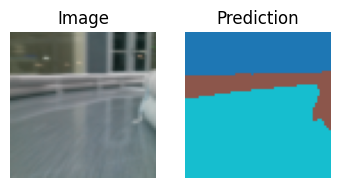

75


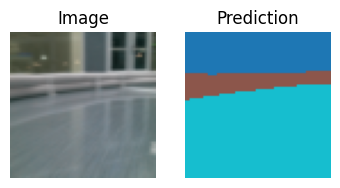

76


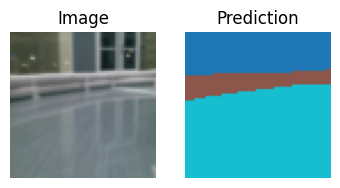

77


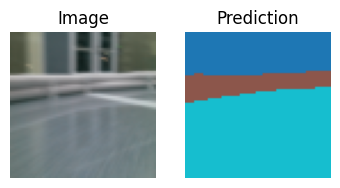

78


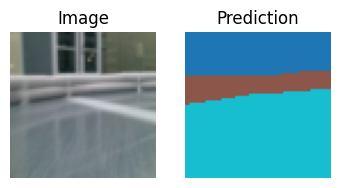

79


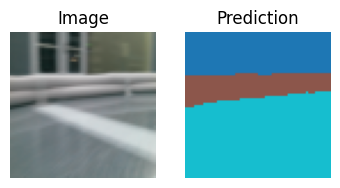

80


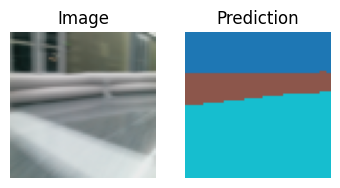

81


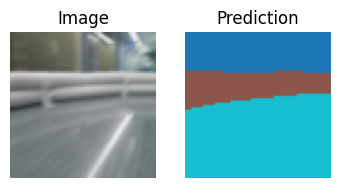

82


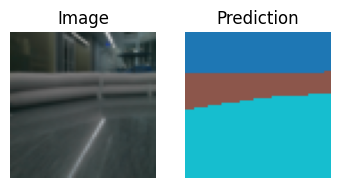

83


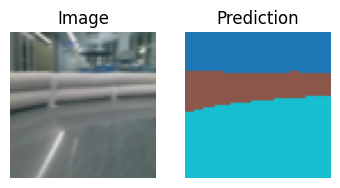

84


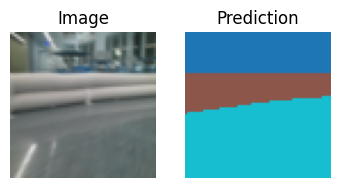

85


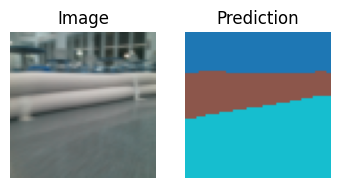

86


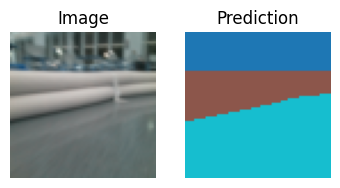

87


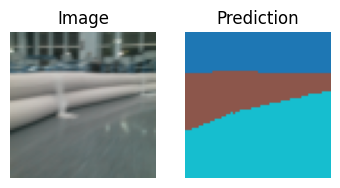

88


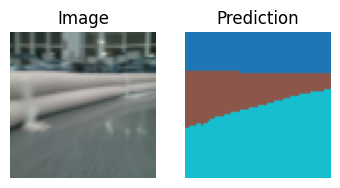

89


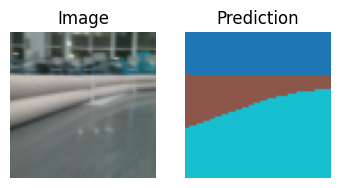

90


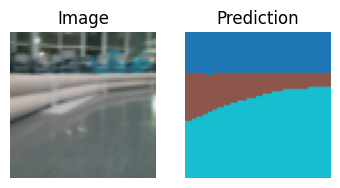

91


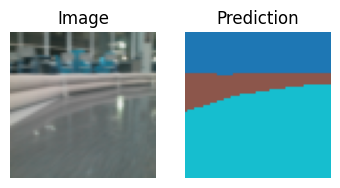

92


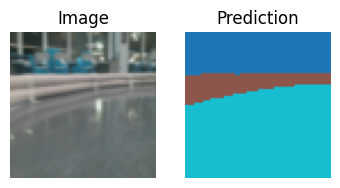

93


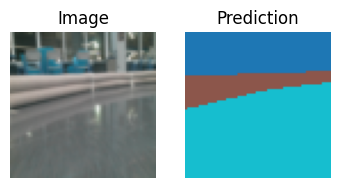

94


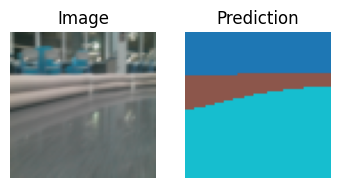

95


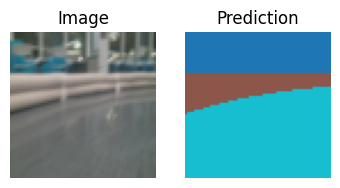

96


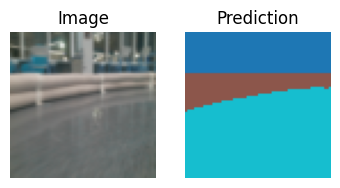

97


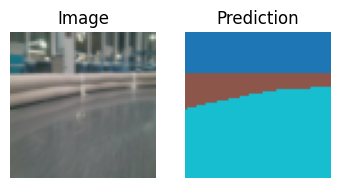

98


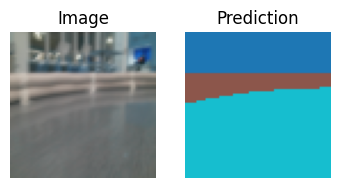

99


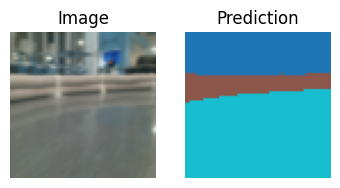

100


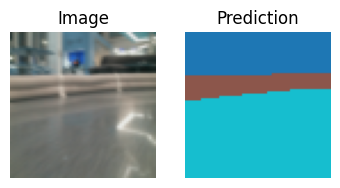

101


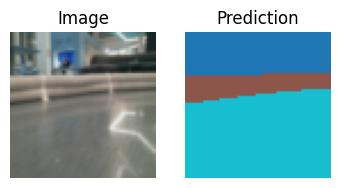

102


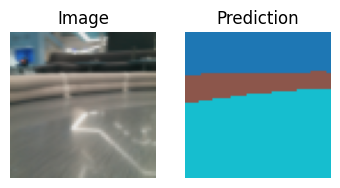

103


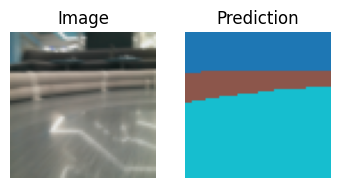

104


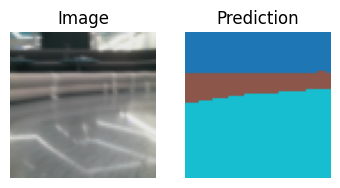

105


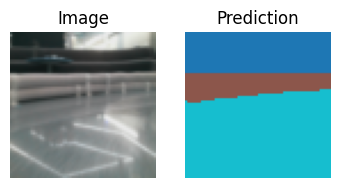

106


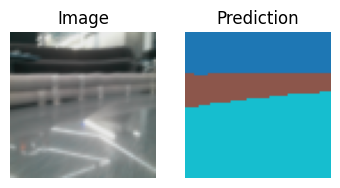

107


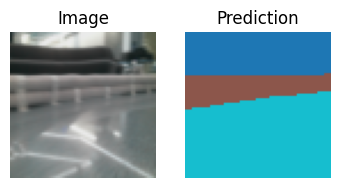

108


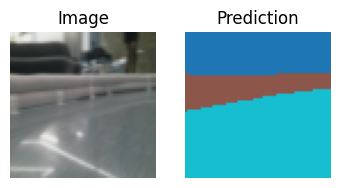

109


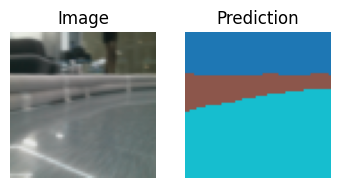

110


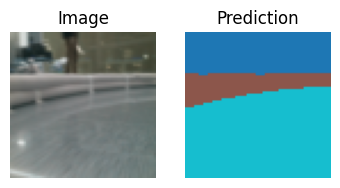

111


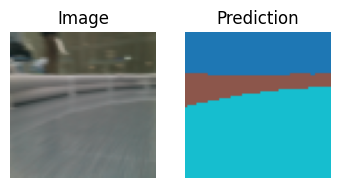

112


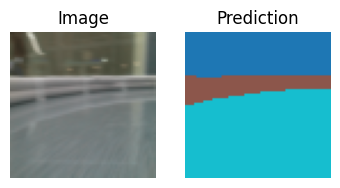

113


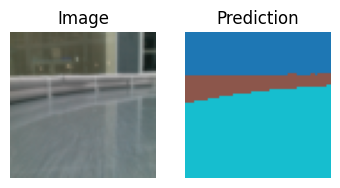

114


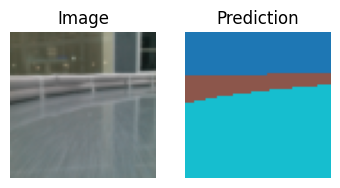

115


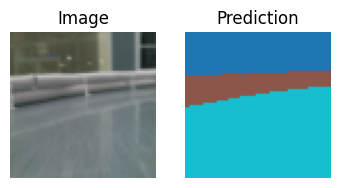

116


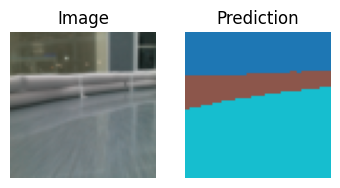

117


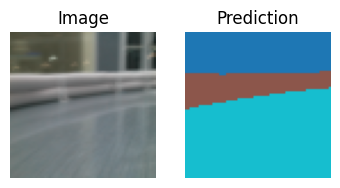

118


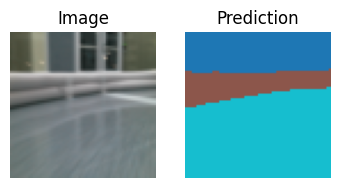

119


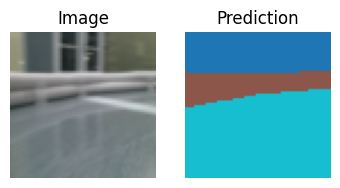

120


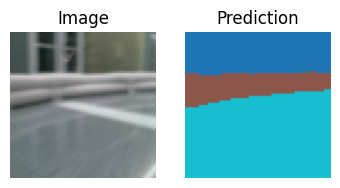

121


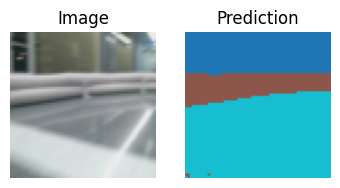

122


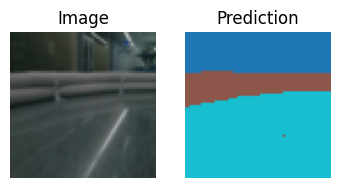

123


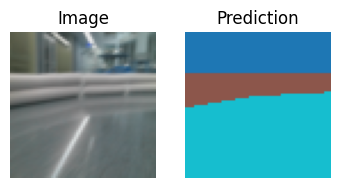

124


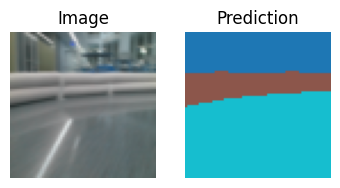

125


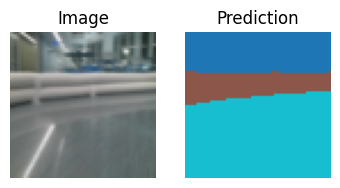

126


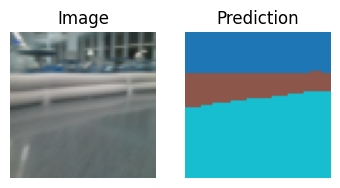

127


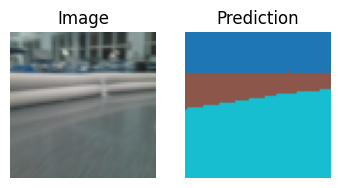

128


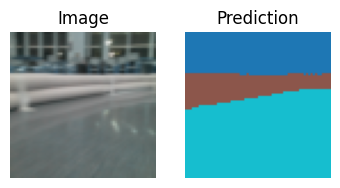

129


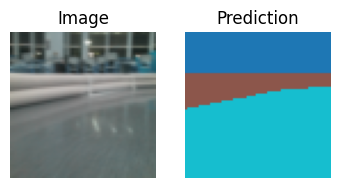

130


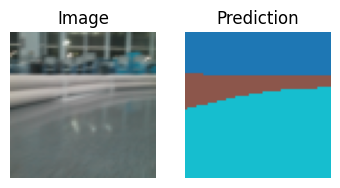

131


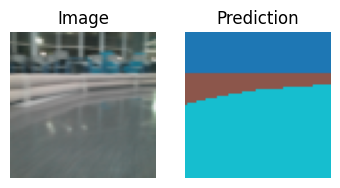

132


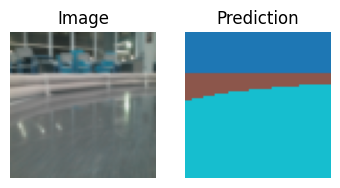

133


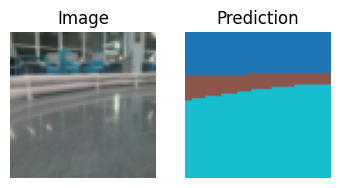

134


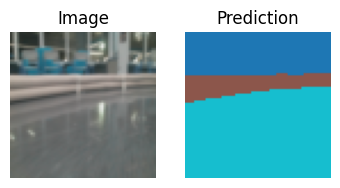

135


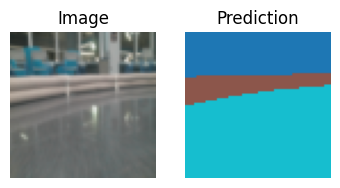

136


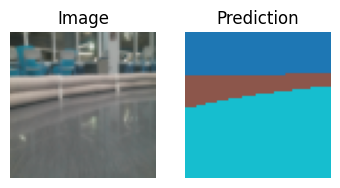

137


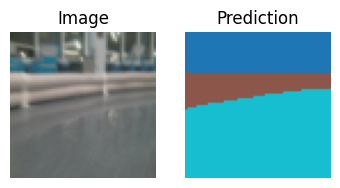

138


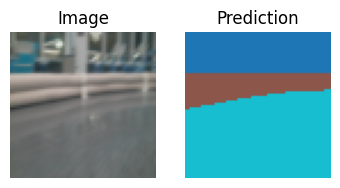

139


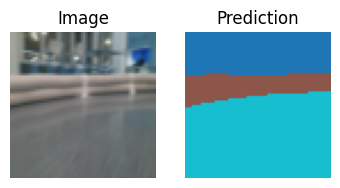

140


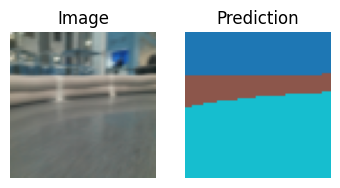

141


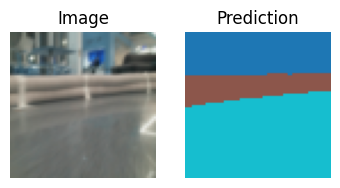

142


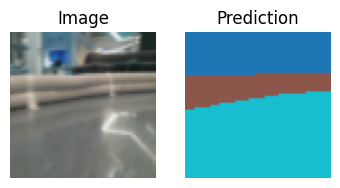

143


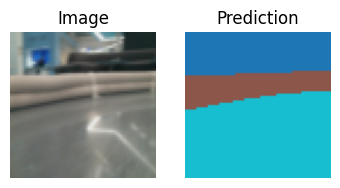

144


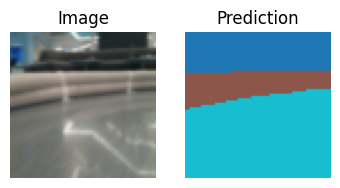

145


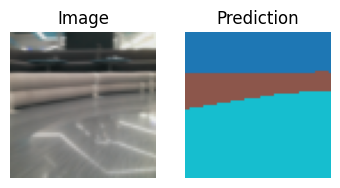

146


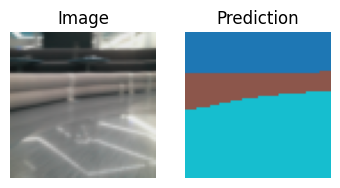

147


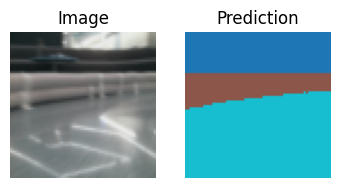

148


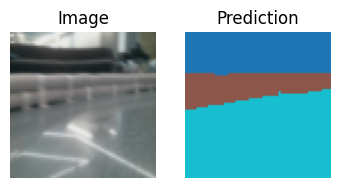

149


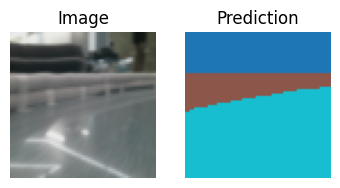

150


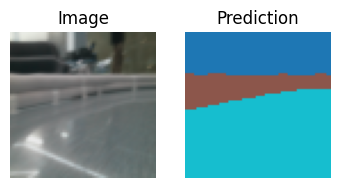

151


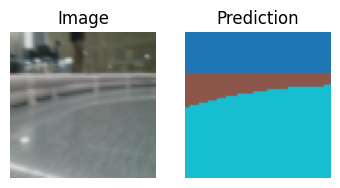

152


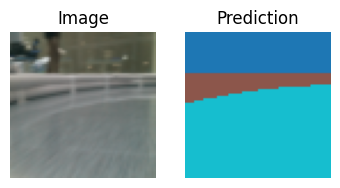

153


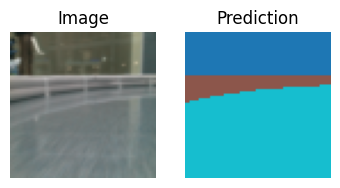

154


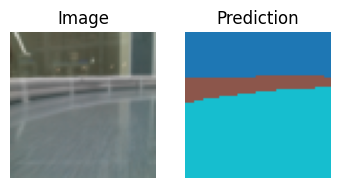

155


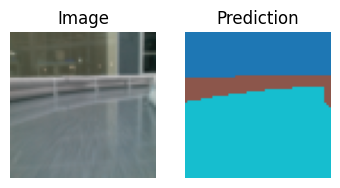

156


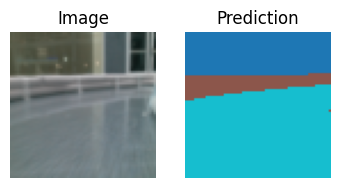

157


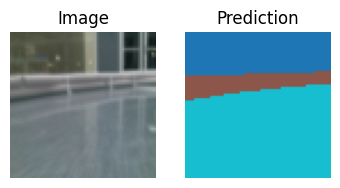

158


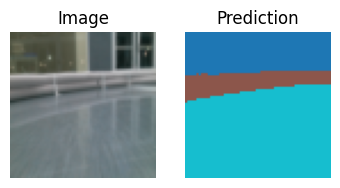

159


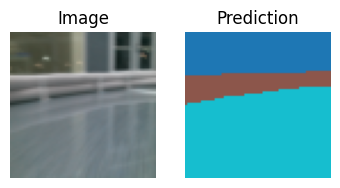

160


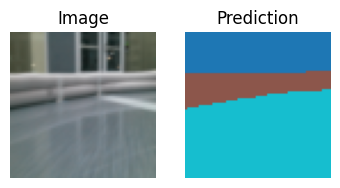

161


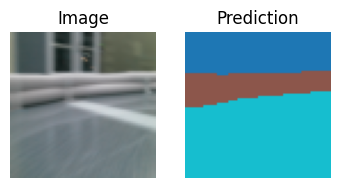

162


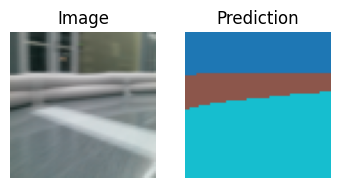

163


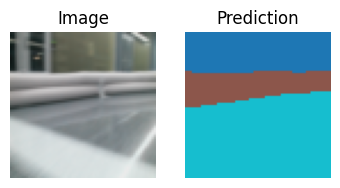

164


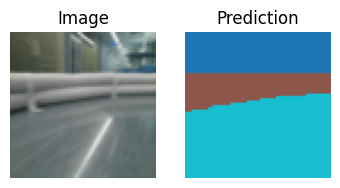

165


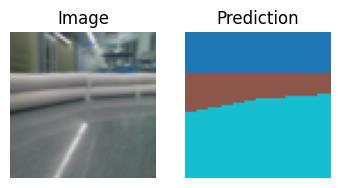

166


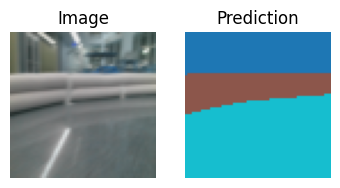

167


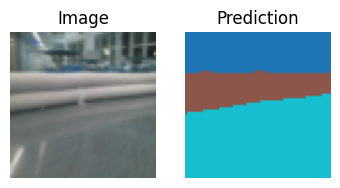

168


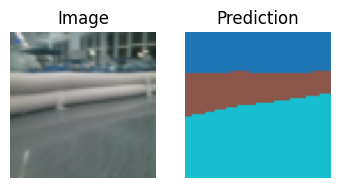

169


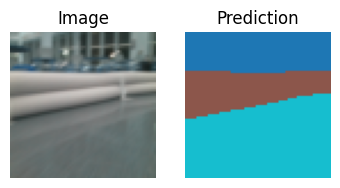

170


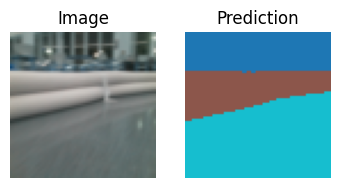

171


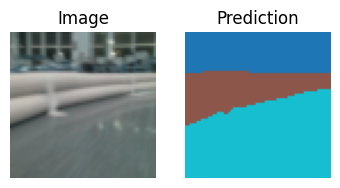

172


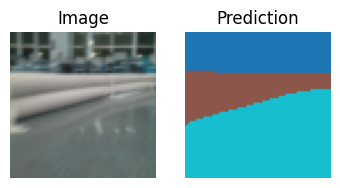

173


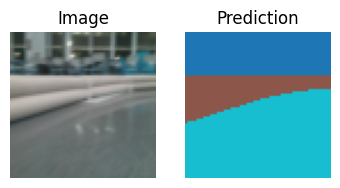

174


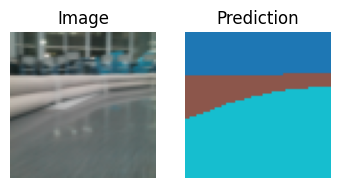

175


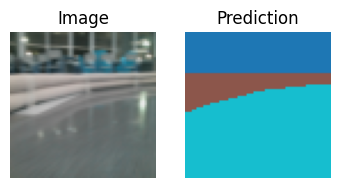

176


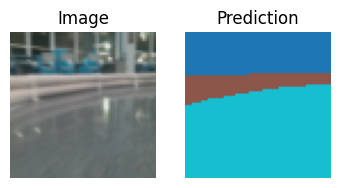

177


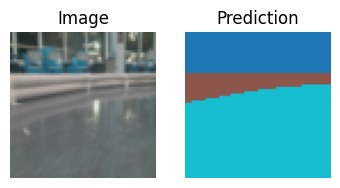

178


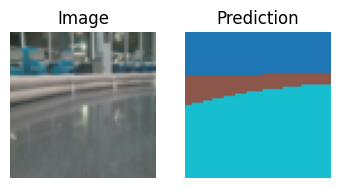

179


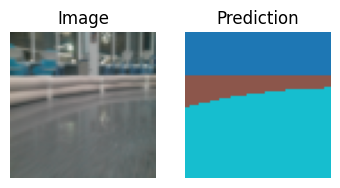

180


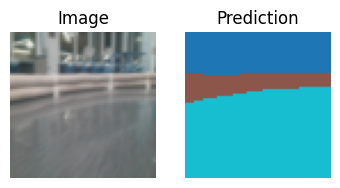

181


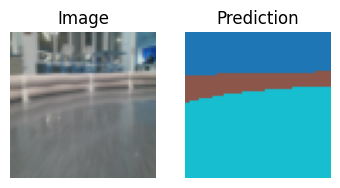

182


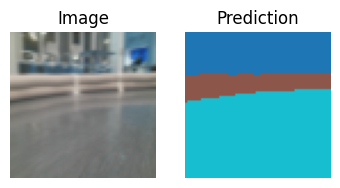

183


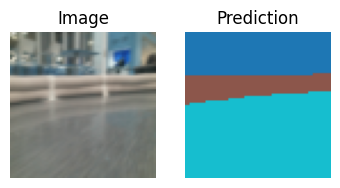

184


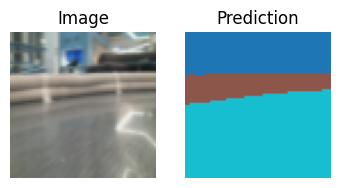

185


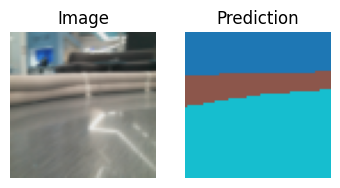

186


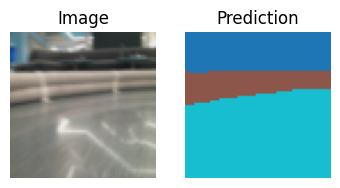

187


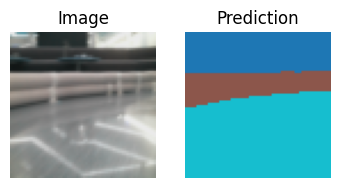

188


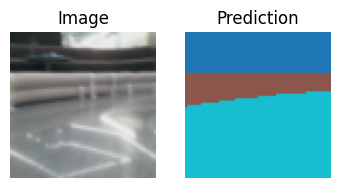

189


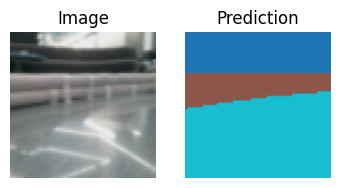

190


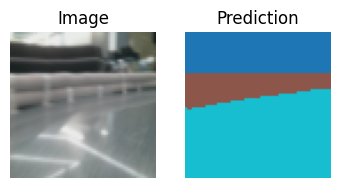

191


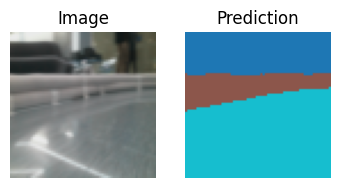

192


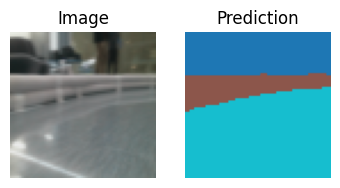

193


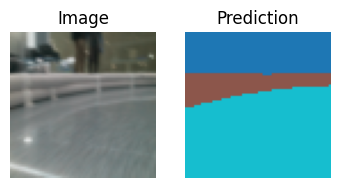

194


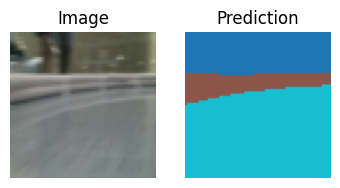

195


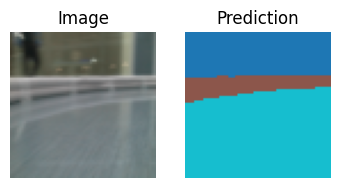

196


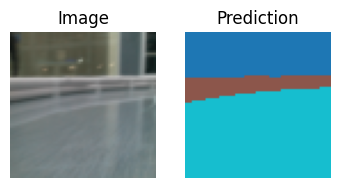

197


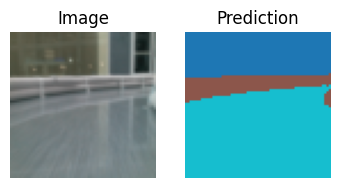

198


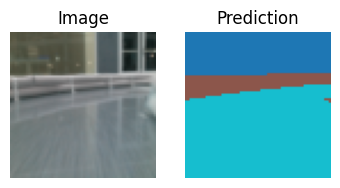

199


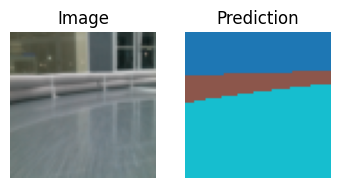

200


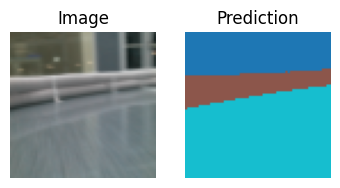

201


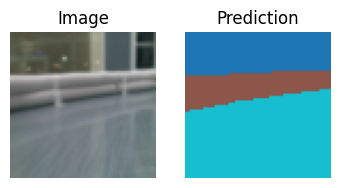

202


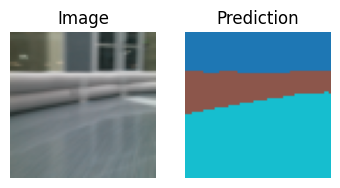

203


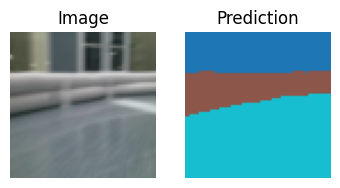

204


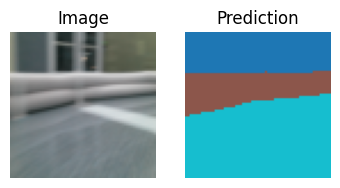

205


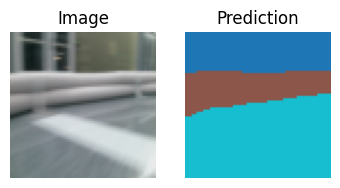

206


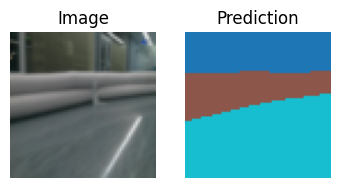

207


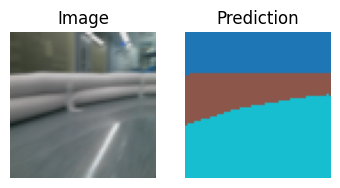

208


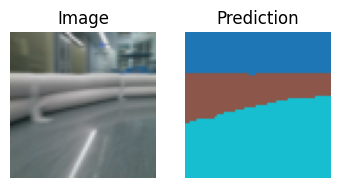

209


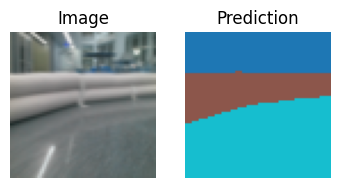

210


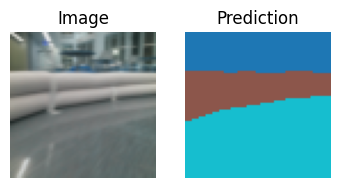

211


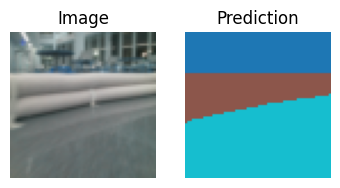

212


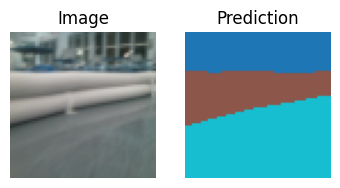

213


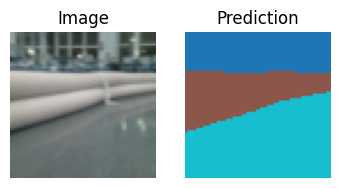

214


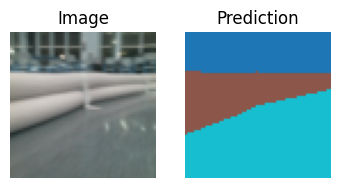

215


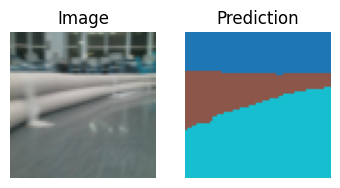

216


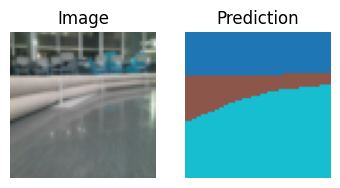

217


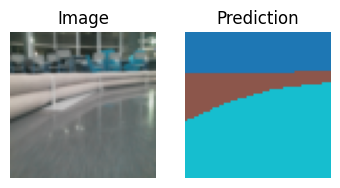

218


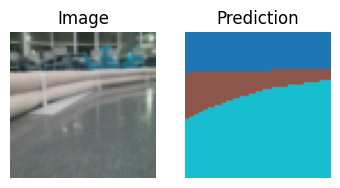

219


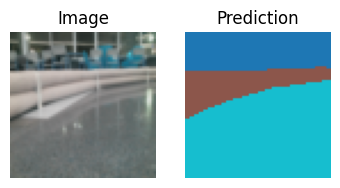

220


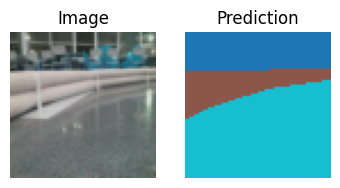

221


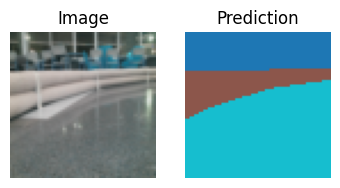

222


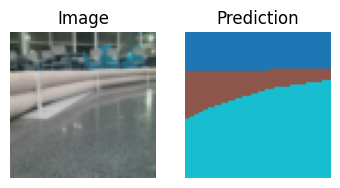

223


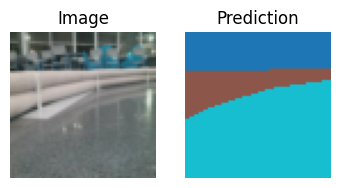

224


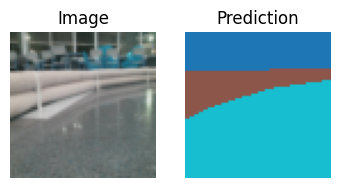

225


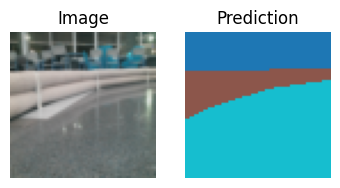

226


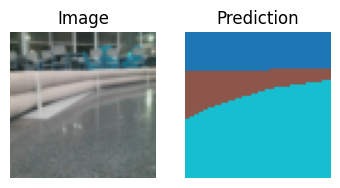

227


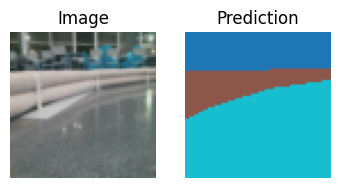

228


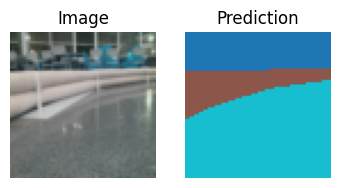

229


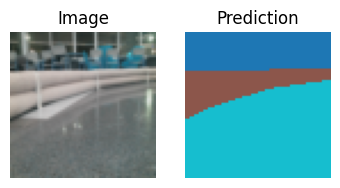

230


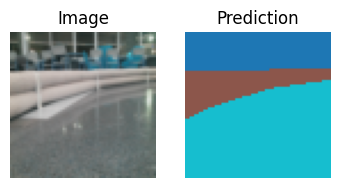

In [8]:
import matplotlib.pyplot as plt
# print(targets_res[0].shape)

def dice_loss(y_true, y_pred, smooth=1e-5):
    intersection = torch.sum(y_true * y_pred, dim=(1,2,3))
    sum_of_squares_pred = torch.sum(torch.square(y_pred), dim=(1,2,3))
    sum_of_squares_true = torch.sum(torch.square(y_true), dim=(1,2,3))
    dice = 1 - (2 * intersection + smooth) / (sum_of_squares_pred + sum_of_squares_true + smooth)
    return dice

# y_true = torch.zeros(len(images),4,64,64)
y_pred = torch.zeros(len(images),4,64,64)

# print(y_true.shape)
for i in range(len(images)):
    # temp = torch.zeros(64,64)
    # temp[targets_res[i]==0] = 1
    # y_true[i,0,:,:] = temp 

    # temp = torch.zeros(64,64)
    # temp[targets_res[i]==1] = 1
    # y_true[i,1,:,:] = temp

    # temp = torch.zeros(64,64)
    # temp[targets_res[i]==2] = 1
    # y_true[i,2,:,:] = temp

    # temp = torch.zeros(64,64)
    # temp[targets_res[i]==3] = 1
    # y_true[i,3,:,:] = temp
    
    # print(output[i])
    temp1 = torch.zeros(64,64)
    temp1[output[i]==0] = 1
    y_pred[i,0,:,:] = temp1 

    temp1 = torch.zeros(64,64)
    temp1[output[i]==1] = 1
    y_pred[i,1,:,:] = temp1

    temp1 = torch.zeros(64,64)
    temp1[output[i]==2] = 1
    y_pred[i,2,:,:] = temp1

    temp1 = torch.zeros(64,64)
    temp1[output[i]==3] = 1
    y_pred[i,3,:,:] = temp1

# dice = dice_loss(y_true, y_pred)

# print(1-dice)
# print(torch.min(1-dice))
# print(torch.argmin(1-dice)+1)
# print(torch.mean(1-dice))

for i in range(len(images)):  
    if i>=0:
        print(i+1)
        plt.subplot(131)
        plt.imshow(images_res[i])
        plt.title("Image")
        plt.axis('off')
        plt.imsave(f'saved_images/real/real_{i}.png', images_res[i])
        ##uncomment the following to see the target/labelled/ground-truth segmentation maks along with other two images
        # plt.subplot(132)
        # temp1 = np.zeros((64, 64, 3), dtype=np.uint8)
        # temp1[targets_res[i]==0] = [30, 119, 180]
        # temp1[targets_res[i]==1] = [140, 86, 75]
        # temp1[targets_res[i]==2] = [22, 190, 207]
        # temp1[targets_res[i]==3] = [220, 19, 20]
        # # plt.imshow(output[i]*127, cmap='gray')
        # plt.imshow(temp1)
        # plt.title("Target")
        # plt.axis('off')
        
        plt.subplot(132)
        temp = np.zeros((64, 64, 3), dtype=np.uint8)
        temp[output[i]==0] = [30, 119, 180]
        temp[output[i]==1] = [140, 86, 75]
        temp[output[i]==2] = [22, 190, 207]
        temp[output[i]==3] = [220, 19, 20]
        plt.imshow(temp)
        plt.imsave(f'saved_images/pred/pred_{i}.png', temp)
        plt.title("Prediction")
        plt.axis('off')    
        
        plt.show()

In [ ]:
import matplotlib.pyplot as plt
# print(targets_res[0].shape)

def dice_loss(y_true, y_pred, smooth=1e-5):
    intersection = torch.sum(y_true * y_pred, dim=(1,2,3))
    sum_of_squares_pred = torch.sum(torch.square(y_pred), dim=(1,2,3))
    sum_of_squares_true = torch.sum(torch.square(y_true), dim=(1,2,3))
    dice = 1 - (2 * intersection + smooth) / (sum_of_squares_pred + sum_of_squares_true + smooth)
    return dice

# y_true = torch.zeros(len(images),4,64,64)
y_pred = torch.zeros(len(images),4,64,64)

print(len(images))
for i in range(len(images)):
    # print(output[i])
    temp1 = torch.zeros(64,64)
    temp1[output[i]==0] = 1
    y_pred[i,0,:,:] = temp1 

    temp1 = torch.zeros(64,64)
    temp1[output[i]==1] = 1
    y_pred[i,1,:,:] = temp1

    temp1 = torch.zeros(64,64)
    temp1[output[i]==2] = 1
    y_pred[i,2,:,:] = temp1

    temp1 = torch.zeros(64,64)
    temp1[output[i]==3] = 1
    y_pred[i,3,:,:] = temp1

# dice = dice_loss(y_true, y_pred)

# print(1-dice)
# print(torch.min(1-dice))
# print(torch.argmin(1-dice)+1)
# print(torch.mean(1-dice))

for i in range(len(images)):  
    if i>=0:
        print(i+1)
        plt.subplot(131)
        plt.imshow(images_res[i])
        plt.title("Image")
        plt.axis('off')
        
        # plt.subplot(132)
        # temp1 = np.zeros((64, 64, 3), dtype=np.uint8)
        # temp1[targets_res[i]==0] = [30, 119, 180]
        # temp1[targets_res[i]==1] = [140, 86, 75]
        # temp1[targets_res[i]==2] = [22, 190, 207]
        # temp1[targets_res[i]==3] = [220, 19, 20]
        # # plt.imshow(output[i]*127, cmap='gray')
        # plt.imshow(temp1)
        # plt.title("Target")
        # plt.axis('off')
        
        plt.subplot(132)
        temp = np.zeros((64, 64, 3), dtype=np.uint8)
        temp[output[i]==0] = [30, 119, 180]
        temp[output[i]==1] = [140, 86, 75]
        temp[output[i]==2] = [22, 190, 207]
        temp[output[i]==3] = [220, 19, 20]
        plt.imshow(temp)
        plt.title("Prediction")
        plt.axis('off')    
        
        plt.show()

0
